In [1]:
import nglview as ng
import mdtraj as md
import pandas as pd

In [2]:
# https://www.rcsb.org/structure/1FJS
# ng.show_structure_file('1fjs.pdb')
view = ng.show_pdbid("3fjs")
view.add_surface(selection="protein", opacity=0.2)
view.add_licorice('ALA')
view

NGLWidget()

In [3]:
def clean_pdb(input_file, output_file):
    """
    This cleaning procedure is not universally appropriate 
    (e.g., the case of a tightly bound ligand or otherwise functional active-site water molecule).
    
    HETATM stands for "HETero ATom":

        These records represent atoms in non-standard residues such as ligands, inhibitors,
    solvent molecules (like water), ions, and modified amino acids
        By removing lines with HETATM, you're keeping only the standard protein structure (the amino acid chain)


    CONECT stands for "CONnECTivity":

        These records specify the connectivity between atoms, particularly for non-standard residues
    They define chemical bonds between atoms that might not be inferred from standard geometry
    Removing CONECT records simplifies the file by eliminating these explicit bond definitions
    """
    with open(input_file, 'r') as f_in:
        with open(output_file, 'w') as f_out:
            for line in f_in:
                if line.startswith('HETATM'):
                    continue
                if line.startswith('CONECT'):
                    continue
                f_out.write(line)

In [4]:
clean_pdb('1fjs.pdb', '1fjs_protein.pdb')

In [5]:
#  Always check your .pdb file for entries listed under the comment MISSING,
# as these entries indicate either atoms or whole residues that are not present in the crystal structure.
# Terminal regions may be absent, and may not present a problem for dynamics.
"""
Protein crystal structures often have incomplete regions, particularly at the N-terminal and C-terminal ends
(the beginning and end of the protein chain).
When you see "MISSING" in a PDB file, it means those parts weren't resolved in the experimental structure
determination.

The note about terminal regions "not presenting a problem for dynamics" means:

1. Missing terminal regions (ends of the protein) are typically flexible and disordered in solution,
    which is why they often don't show up clearly in crystal structures
2. For molecular dynamics simulations, having these terminal regions missing is usually acceptable because:
   - They're often not crucial for the core protein function or structure
   - They typically extend into the solvent and don't participate in important structural interactions
   - The dynamics of the rest of the protein can still be studied meaningfully without them

However, if missing regions are in the middle of the protein or in functionally important areas
(like active sites or binding interfaces), that would be more problematic for a simulation.
Those gaps would need to be addressed by modeling the missing sections before running dynamics.
"""
!grep MISSING 1fjs.pdb

In [6]:
view = ng.show_structure_file("1fjs_protein.pdb")
#view.add_surface(selection="protein", opacity=0.2)
view.add_licorice('ALA')
view

NGLWidget()

# Topology

In [8]:
!gmx_mpi pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff "charmm27"

                     :-) GROMACS - gmx pdb2gmx, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff charmm27

Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
Opening force field file /usr/local/gromacs/share/gromacs/top/charmm27.ff/aminoacids.r2b

going to rename charmm27.ff/rna.r2b
Opening force field file /usr/local/gromacs/share/gromacs/top/charmm27.ff/rna.r2b
Reading 1fjs_protein.pdb...
Read 'COAGULATION FACTOR XA; COAGULATION FACTOR XA', 2236 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 2 chains and 0 blocks of water and 286 residues with 2236 atoms

  chain  #res #atoms

  1 'A'   234   1852  

  2 'L'    52    384  

there were 14 atoms with zero occupancy and 20 atoms with          occupancy unequal to

In [9]:
!cat topol.top

;
;	File 'topol.top' was generated
;	By user: ubuntu (1000)
;	On host: ip-10-0-101-171
;	At date: Tue Mar  4 05:28:42 2025
;
;	This is a standalone topology file
;
;	Created by:
;	                    :-) GROMACS - gmx pdb2gmx, 2025.0 (-:
;	
;	Executable:   /usr/local/gromacs/bin/gmx_mpi
;	Data prefix:  /usr/local/gromacs
;	Working dir:  /home/ubuntu/src/gromacs
;	Command line:
;	  gmx_mpi pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff charmm27
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "charmm27.ff/forcefield.itp"

; Include chain topologies
#include "topol_Protein_chain_A.itp"
#include "topol_Protein_chain_L.itp"

; Include water topology
#include "charmm27.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif

; Include topology for ions
#include "charmm27.ff/

In [10]:
!grep "moleculetype" -A 3 topol_Protein_chain_A.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_A     3



In [11]:
!grep "moleculetype" -A 3 topol_Protein_chain_L.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_L     3



In [12]:
! grep "atoms" -A 4 topol_Protein_chain_A.itp

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
; residue  16 ILE rtp ILE  q +1.0
     1        NH3     16    ILE      N      1       -0.3     14.007
     2         HC     16    ILE     H1      2       0.33      1.008


In [13]:
!grep "bonds" -A 2 topol_Protein_chain_A.itp

[ bonds ]
;  ai    aj funct            c0            c1            c2            c3
    1     2     1 


In [14]:
!grep "pairs" -A 2  topol_Protein_chain_A.itp

[ pairs ]
;  ai    aj funct            c0            c1            c2            c3
    1     8     1 


In [15]:
!grep "angles" -A 2 topol_Protein_chain_A.itp

[ angles ]
;  ai    aj    ak funct            c0            c1            c2            c3
    2     1     3     5 


In [16]:
!grep "dihedrals" -A 2 topol_Protein_chain_A.itp

[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3            c4            c5
    2     1     5     6     9 
--
[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3
   20     5    22    21     2 


In [17]:
!grep "posre" topol*.itp

topol_Protein_chain_A.itp:#include "posre_Protein_chain_A.itp"
topol_Protein_chain_L.itp:#include "posre_Protein_chain_L.itp"


In [18]:
!head posre_Protein_chain_A.itp

; In this topology include file, you will find position restraint
; entries for all the heavy atoms in your original pdb file.
; This means that all the protons which were added by pdb2gmx are
; not restrained.

[ position_restraints ]
; atom  type      fx      fy      fz
     1     1  1000  1000  1000
     5     1  1000  1000  1000
     7     1  1000  1000  1000


In [19]:
!grep "Include water topology" -A 8 topol.top

; Include water topology
#include "charmm27.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif


In [20]:
!grep "ions" topol.top

; Include topology for ions
#include "charmm27.ff/ions.itp"


In [21]:
!tail -8 topol.top

[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1


# Defining the simulation box

In [22]:
!gmx_mpi editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

                     :-) GROMACS - gmx editconf, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 4417 atoms
Volume: 321.98 nm^3, corresponds to roughly 144800 electrons
No velocities found
    system size :  6.066  5.213  4.092 (nm)
    diameter    :  6.268               (nm)
    center      :  2.234  1.342  2.544 (nm)
    box vectors :  5.577  7.196  8.023 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 321.98               (nm^3)
    shift       :  3.967  4.858  0.379 (nm)
new center      :  6.201  6.201  2.923 (nm)
new box vectors :  8.268  8.268  8.268 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 399.60               (nm^3)

GROMACS reminds you: "Jesus No

# Fill it with water

In [23]:
!gmx_mpi solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

                     :-) GROMACS - gmx solvate, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ 

In [24]:
!tail topol.top


[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL             11777


In [26]:
view = ng.show_structure_file("1fjs_solv.gro")
view.add_surface(selection="protein", opacity=0.2)
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()

# Adding ions

In [27]:
!touch ions.mdp

In [28]:
!gmx_mpi grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr


NOTE 1 [file ions.mdp]:
  For a correct single-point energy evaluation with nsteps = 0, use
  continuation = yes to avoid constraining the input coordinates.

Setting the LD random seed to -1091568262

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file topol.top, line 48]:
  System has non-zero total charge: -2.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html

In [30]:
!printf "SOL\n" | gmx_mpi genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p topol.top -pname NA -nname CL -neutral  

                      :-) GROMACS - gmx genion, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p topol.top -pname NA -nname CL -neutral

Reading file ions.tpr, VERSION 2025.0 (single precision)
Reading file ions.tpr, VERSION 2025.0 (single precision)
Will try to add 38 NA ions and 36 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 39748 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    1

In [31]:
!tail -8 topol.top


[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL         11703
NA               38
CL               36


In [30]:
view = ng.show_structure_file("1fjs_solv_ions.gro")
view.add_surface(selection="protein", opacity=0.2)

view.add_representation(repr_type='spacefill', selection='NA')
view.add_representation(repr_type='spacefill', selection='CL')
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'
view

NGLWidget()

# Energy minimization

In [31]:
!gmx_mpi grompp -f emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

                      :-) GROMACS - gmx grompp, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi grompp -f emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -1821683395

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...
Analysing residue names:
Th

In [32]:
!mpirun -np 2 gmx_mpi mdrun -deffnm em -ntomp 2

                      :-) GROMACS - gmx mdrun, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi mdrun -deffnm em -ntomp 2


Back Off! I just backed up em.log to ./#em.log.6#
Reading file em.tpr, VERSION 2025.0 (single precision)
Using 2 MPI processes

Non-default thread affinity set, disabling internal thread affinity

Using 2 OpenMP threads per MPI process


Back Off! I just backed up em.trr to ./#em.trr.4#

Back Off! I just backed up em.edr to ./#em.edr.4#

Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =           -1

writing lowest energy coordinates.

Back Off! I just backed up em.gro to ./#em.gro.4#

Steepest Descents converged to Fmax < 1000 in 760 steps
Potential Energy  = -6.1369144e+05
Maximum force     =  9.3193573e+02 on atom 3836
Norm of force     =  2.1141010e+01

GROMACS reminds you: "I Don't Like Dirt" (The Breeders)



In [33]:
!printf "Potential\n0\n" | gmx_mpi energy -f em.edr -o potential.xvg -xvg none

                      :-) GROMACS - gmx energy, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi energy -f em.edr -o potential.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ          20  Vir-ZX        
 21  Vir-ZY          22  Vir-ZZ          23  Pres-XX         24  Pres

<Axes: xlabel='step'>

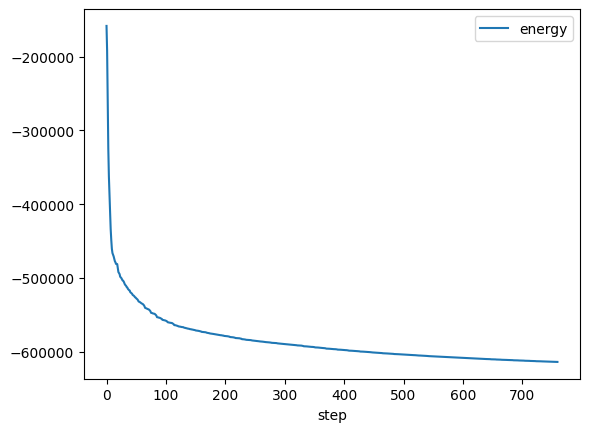

In [34]:
df = pd.read_csv('potential.xvg', sep='\\s+', header=None, names=['step','energy'])
df.plot('step')

In [47]:
"""
Select group for centering then for output
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (    Prot-Masses) has  4417 elements
Group    11 (    non-Protein) has 35183 elements
Group    12 (          Water) has 35109 elements
Group    13 (            SOL) has 35109 elements
Group    14 (      non-Water) has  4491 elements
Group    15 (            Ion) has    74 elements
Group    16 ( Water_and_ions) has 35183 elements
"""
!printf "1\n1\n" | gmx_mpi trjconv -s em.tpr -f em.trr -o em_center.xtc -center -pbc mol

                     :-) GROMACS - gmx trjconv, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi trjconv -s em.tpr -f em.trr -o em_center.xtc -center -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file em.tpr, VERSION 2025.0 (single precision)
Reading file em.tpr, VERSION 2025.0 (single precision)
Select group for centering
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements


In [48]:
# Convert the TPR file to a structure file
!gmx_mpi editconf -f em.tpr -o em_full.gro

                     :-) GROMACS - gmx editconf, 2025.0 (-:

Executable:   /usr/local/gromacs/bin/gmx_mpi
Data prefix:  /usr/local/gromacs
Working dir:  /home/ubuntu/src/gromacs
Command line:
  gmx_mpi editconf -f em.tpr -o em_full.gro

Note that major changes are planned in future for editconf, to improve usability and utility.
Reading file em.tpr, VERSION 2025.0 (single precision)
Reading file em.tpr, VERSION 2025.0 (single precision)
Read 39600 atoms
Volume: 399.595 nm^3, corresponds to roughly 179800 electrons
No velocities found

Back Off! I just backed up em_full.gro to ./#em_full.gro.5#

GROMACS reminds you: "Calling a system 'non-linear' is like calling all wild animals 'non-elephants'." (Stan Ulam)



In [50]:
traj = md.load("em_center.xtc", top="1fjs_newbox.gro")
#traj = md.load("em_center.xtc", top="em_full.gro") #top="em.gro")


view = ng.show_mdtraj(traj)
view.add_surface(selection="protein", opacity=0.2)

view.add_representation(repr_type='spacefill', selection='NA')
view.add_representation(repr_type='spacefill', selection='CL')
view.add_representation(repr_type='ball+stick', selection='SOL')
view.camera='orthographic'

view

NGLWidget(max_frame=60)

In [39]:
# Print the residue names to see what's in your trajectory
residue_names = set(residue.name for residue in traj.topology.residues)
print("Residue names in trajectory:", residue_names)

# Count the water molecules
num_water = sum(1 for res in traj.topology.residues if res.name == 'SOL')
print("Number of water molecules:", num_water)

Residue names in trajectory: {'TYR', 'ALA', 'ARG', 'CL', 'TRP', 'NA', 'VAL', 'SER', 'PHE', 'ASP', 'GLU', 'HIS', 'GLY', 'LEU', 'MET', 'HOH', 'ASN', 'CYS', 'GLN', 'ILE', 'LYS', 'THR', 'PRO'}
Number of water molecules: 0


In [40]:
# Check topology contents
top = md.load_topology("em_full.gro")
residue_names = set(residue.name for residue in top.residues)
print("Residue names in topology:", residue_names)
print("Number of water molecules in topology:", sum(1 for res in top.residues if res.name == 'SOL'))

Residue names in topology: {'TYR', 'ALA', 'ARG', 'CL', 'TRP', 'NA', 'VAL', 'SER', 'PHE', 'ASP', 'GLU', 'HIS', 'GLY', 'LEU', 'MET', 'HOH', 'ASN', 'CYS', 'GLN', 'ILE', 'LYS', 'THR', 'PRO'}
Number of water molecules in topology: 0
